In [1]:
%load_ext autoreload
%autoreload 2



import experiment_code.neural.draw_utils.plot_experiments as drawer
import mlflow
import ast

MLFLOW_PATH = "./../mlruns"
mlflow.set_tracking_uri(MLFLOW_PATH)

drawer.DURATION_KEY = 'pull_rew.eval_rez.duration'

drawer.METRIC_KEYS = [
        'alg_name',
        "pulled_arm",
        'pull_rew.confidence_bound',
        'pull_rew.value',

        'pull_rew.eval_rez.loss',
        'pull_rew.eval_rez.duration',
        'pull_rew.eval_rez.accuracy',

        'test_rew.loss',
        'test_rew.duration',
        'test_rew.accuracy'
    ]


def process_run(run_id, client, n_arms, ARM_KEY):
    run_res = []
    for key in drawer.METRIC_KEYS:
        metric_h = client.get_metric_history(run_id, key=key)
        
        T = len(metric_h)
        if len(run_res) < T:
            run_res = [{} for i in range(T)]

        for i, elem in enumerate(metric_h):                
            run_res[i][key] = int(elem.value) if key == ARM_KEY else elem.value
                
    return run_res

def get_best_alg(run_res, budget = -1):
    print(sorted(run_res[:budget], key = lambda x: x["pull_rew.eval_rez.loss"]))
    return sorted(run_res[:budget], key = lambda x: x["pull_rew.eval_rez.loss"])[0]

def get_runs_by_name(EXP_NAME, RUN_NAME_ST):
    experiment = mlflow.get_experiment_by_name(EXP_NAME)
    runs = mlflow.search_runs(experiment.experiment_id)

    filter_params = {}
    filter_params["RUN_NAME_ST"] = RUN_NAME_ST
    selected_runs = runs.apply(lambda x: drawer.runs_filter(x, filter_params), axis=1)

    run_ids = runs[selected_runs]['run_id'].values

#     # set client and process runs separately
    client = mlflow.MlflowClient()

#     # get experiment names
    run = client.get_run(run_ids[0])
    return run_ids, run, client

def get_hyperband(EXP_NAME: str = "experiments_cycle_50"):
    N_ARMS: int = 11
    RUN_NAME_ST: str = "mab_train;Hyperband"
    

    run_ids, run, client = get_runs_by_name(EXP_NAME, RUN_NAME_ST)

    # get alg_names
    a = run.data.params["model_names_hash"]
    a = a[81:-1] if a.startswith("defaultdict") else a
    alg_names =  ast.literal_eval(a)
    alg_names = {v: k for k, v in alg_names.items()}
    print(len(alg_names))
    assert len(alg_names) == N_ARMS

    run_results = [process_run(run_id, client, N_ARMS, "alg_name") for run_id in run_ids]

    return run_results, alg_names

def get_others(RUN_NAME_ST, EXP_NAME: str = "experiments_cycle_50"):
    N_ARMS: int = 11

    run_ids, run, client = get_runs_by_name(EXP_NAME, RUN_NAME_ST)
# get experiments
    experiment = mlflow.get_experiment_by_name(EXP_NAME)
    runs = mlflow.search_runs(experiment.experiment_id)

    alg_names =  ast.literal_eval(run.data.params["alg_names"])

    assert len(alg_names) == N_ARMS

    run_results = [process_run(run_id, client, N_ARMS, "pulled_arm") for run_id in run_ids]


    return run_results, alg_names

In [2]:
BUDGET = 100

In [3]:
EXP_NAME = "cifar100_500"
run_names = ["mab_train;UCB_2-"] #, "mab_train;SuccessiveHalving-"]

hyperband_res = get_hyperband(EXP_NAME=EXP_NAME)

others_res = [get_others(r_st,EXP_NAME=EXP_NAME) for r_st in run_names]

11


In [4]:
hyperband_bests = [get_best_alg(run_res, budget=BUDGET) for run_res in hyperband_res[0]]
hyperband_bests = [(hyperband_res[1][hr["alg_name"]], hr["pull_rew.eval_rez.loss"]) for hr in hyperband_bests]


def get_other_res(other_res):
    alg_names = other_res[1]
    alg_res = other_res[0]
    alg_bests = [get_best_alg(res,budget=BUDGET) for res in alg_res]
    best_alg = [(alg_names[ab["pulled_arm"]], ab['pull_rew.eval_rez.loss']) for ab in alg_bests]
    return best_alg

others_rank = [get_other_res(res) for res in others_res]

result = {"hyperband": hyperband_bests, **{rn[10:-1]: rr for rn, rr in zip(run_names, others_rank)}}
result

[{'alg_name': 11, 'pull_rew.confidence_bound': 0.20412414523193154, 'pull_rew.value': 3.870733006286621, 'pull_rew.eval_rez.loss': 3.870733006286621, 'pull_rew.eval_rez.duration': 0.0, 'pull_rew.eval_rez.accuracy': 0.104}, {'alg_name': 11, 'pull_rew.confidence_bound': 0.20851441405707477, 'pull_rew.value': 3.9047535591125486, 'pull_rew.eval_rez.loss': 3.9047535591125486, 'pull_rew.eval_rez.duration': 0.0, 'pull_rew.eval_rez.accuracy': 0.093}, {'alg_name': 11, 'pull_rew.confidence_bound': 0.21320071635561041, 'pull_rew.value': 3.91929760093689, 'pull_rew.eval_rez.loss': 3.91929760093689, 'pull_rew.eval_rez.duration': 0.0, 'pull_rew.eval_rez.accuracy': 0.0934}, {'alg_name': 11, 'pull_rew.confidence_bound': 0.2182178902359924, 'pull_rew.value': 3.935099737548828, 'pull_rew.eval_rez.loss': 3.935099737548828, 'pull_rew.eval_rez.duration': 0.0, 'pull_rew.eval_rez.accuracy': 0.0914}, {'alg_name': 11, 'pull_rew.confidence_bound': 0.22360679774997896, 'pull_rew.value': 3.9541630634307863, 'pull

{'hyperband': [('cifar100_shufflenetv2_x1_5', 3.870733006286621),
  ('cifar100_mobilenetv2_x0_75', 3.976649983215332),
  ('cifar100_mobilenetv2_x0_75', 3.8821515769958497),
  ('cifar100_shufflenetv2_x1_5', 3.8557181339263917),
  ('cifar100_shufflenetv2_x1_5', 3.876775302886963),
  ('cifar100_shufflenetv2_x1_5', 3.9167890895843507),
  ('cifar100_shufflenetv2_x1_5', 3.8522833969116212),
  ('cifar100_shufflenetv2_x1_5', 3.894599781036377),
  ('cifar100_resnet20', 3.9863228553771974),
  ('cifar100_shufflenetv2_x1_5', 3.821671026611328)],
 'UCB_2': [('cifar100_mobilenetv2_x1_4', 4.007905422210693),
  ('cifar100_mobilenetv2_x1_4', 4.1054239685058596),
  ('cifar100_mobilenetv2_x1_4', 4.019503866577148),
  ('cifar100_mobilenetv2_x1_4', 4.091490036010742),
  ('cifar100_mobilenetv2_x1_4', 4.072412735748291),
  ('cifar100_mobilenetv2_x1_4', 4.0578117824554445),
  ('cifar100_mobilenetv2_x1_4', 4.131467388916016),
  ('cifar100_mobilenetv2_x1_4', 4.029969307327271),
  ('cifar100_mobilenetv2_x1_4', 4

In [5]:
import pandas as pd

data = [
    ["resnet20", 68.83, 91.01, 0.28, 40.82],
    ["resnet32", 70.16, 90.89, 0.47, 69.13],
    ["resnet44", 71.63, 91.58, 0.67, 97.44],
    ["resnet56", 72.63, 91.94, 0.86, 125.75],
    ["vgg11_bn", 70.78, 88.87, 9.80, 153.34],
    ["vgg13_bn", 74.63, 91.09, 9.99, 228.84],
    ["vgg16_bn", 74.00, 90.56, 15.30, 313.77],
    ["vgg19_bn", 73.87, 90.13, 20.61, 398.71],
    ["mobilenetv2_x0_5", 70.88, 91.72, 0.82, 28.08],
    ["mobilenetv2_x0_75", 73.61, 92.61, 1.48, 59.43],
    ["mobilenetv2_x1_0", 74.20, 92.82, 2.35, 88.09],
    ["mobilenetv2_x1_4", 75.98, 93.44, 4.50, 170.23],
    ["shufflenetv2_x0_5", 67.82, 89.93, 0.44, 10.99],
    ["shufflenetv2_x1_0", 72.39, 91.46, 1.36, 45.09],
    ["shufflenetv2_x1_5", 73.91, 92.13, 2.58, 94.35],
    ["shufflenetv2_x2_0", 75.35, 92.62, 5.55, 188.00],
    ["repvgg_a0", 75.22, 92.93, 7.96, 489.19],
    ["repvgg_a1", 76.12, 92.71, 12.94, 851.44],
    ["repvgg_a2", 77.18, 93.51, 26.94, 1850.22],
]

columns = ["Model", "Top-1 Acc.(%)", "Top-5 Acc.(%)", "#Params.(M)", "#MAdds(M)"]
model_accs = pd.DataFrame(data, columns=columns)
mini_models = model_accs[model_accs["#Params.(M)"] <= 5]
mini_models['rank'] = mini_models["Top-1 Acc.(%)"].rank(ascending=False)
mini_models

,Model,Top-1 Acc.(%),Top-5 Acc.(%),#Params.(M),#MAdds(M),rank
0,resnet20,68.83,91.01,0.28,40.82,10.0
1,resnet32,70.16,90.89,0.47,69.13,9.0
2,resnet44,71.63,91.58,0.67,97.44,7.0
3,resnet56,72.63,91.94,0.86,125.75,5.0
8,mobilenetv2_x0_5,70.88,91.72,0.82,28.08,8.0
9,mobilenetv2_x0_75,73.61,92.61,1.48,59.43,4.0
10,mobilenetv2_x1_0,74.20,92.82,2.35,88.09,2.0
11,mobilenetv2_x1_4,75.98,93.44,4.50,170.23,1.0
12,shufflenetv2_x0_5,67.82,89.93,0.44,10.99,11.0
13,shufflenetv2_x1_0,72.39,91.46,1.36,45.09,6.0


In [6]:
mini_models[mini_models["Model"] == "mobilenetv2_x1_4"]['rank'].item()

1.0

In [7]:
from typing import Counter
import numpy as np

def get_rank(model_name):
    model_name = model_name[9:]
    return mini_models[mini_models["Model"] == model_name]['rank'].item()

result = {"hyperband": hyperband_bests, **{rn[10:-1]: rr for rn, rr in zip(run_names, others_rank)}}
models = set()
mean_ranks = {}
for k, v in result.items():
    print(k)
    items = [a[0]for a in v]
    rank_list = np.mean([get_rank(m_n) for m_n in items])
    mean_ranks[k] = rank_list
    models.update(items)
    
    print(Counter(items))

hyperband
Counter({'cifar100_shufflenetv2_x1_5': 7, 'cifar100_mobilenetv2_x0_75': 2, 'cifar100_resnet20': 1})
UCB_2
Counter({'cifar100_mobilenetv2_x1_4': 9, 'cifar100_mobilenetv2_x1_0': 1})


In [8]:
mean_ranks

{'hyperband': np.float64(3.9), 'UCB_2': np.float64(1.1)}

In [10]:
mini_models[["Model", "Top-1 Acc.(%)", "#Params.(M)", "#MAdds(M)", "rank"]]

,Model,Top-1 Acc.(%),#Params.(M),#MAdds(M),rank
0,resnet20,68.83,0.28,40.82,10.0
1,resnet32,70.16,0.47,69.13,9.0
2,resnet44,71.63,0.67,97.44,7.0
3,resnet56,72.63,0.86,125.75,5.0
8,mobilenetv2_x0_5,70.88,0.82,28.08,8.0
9,mobilenetv2_x0_75,73.61,1.48,59.43,4.0
10,mobilenetv2_x1_0,74.20,2.35,88.09,2.0
11,mobilenetv2_x1_4,75.98,4.50,170.23,1.0
12,shufflenetv2_x0_5,67.82,0.44,10.99,11.0
13,shufflenetv2_x1_0,72.39,1.36,45.09,6.0


In [11]:
import pandas as pd

data = [
    ["resnet20", 68.83, 91.01, 0.28, 40.82],
    ["resnet32", 70.16, 90.89, 0.47, 69.13],
    ["resnet44", 71.63, 91.58, 0.67, 97.44],
    ["resnet56", 72.63, 91.94, 0.86, 125.75],
    ["vgg11_bn", 70.78, 88.87, 9.80, 153.34],
    ["vgg13_bn", 74.63, 91.09, 9.99, 228.84],
    ["vgg16_bn", 74.00, 90.56, 15.30, 313.77],
    ["vgg19_bn", 73.87, 90.13, 20.61, 398.71],
    ["mobilenetv2_x0_5", 70.88, 91.72, 0.82, 28.08],
    ["mobilenetv2_x0_75", 73.61, 92.61, 1.48, 59.43],
    ["mobilenetv2_x1_0", 74.20, 92.82, 2.35, 88.09],
    ["mobilenetv2_x1_4", 75.98, 93.44, 4.50, 170.23],
    ["shufflenetv2_x0_5", 67.82, 89.93, 0.44, 10.99],
    ["shufflenetv2_x1_0", 72.39, 91.46, 1.36, 45.09],
    ["shufflenetv2_x1_5", 73.91, 92.13, 2.58, 94.35],
    ["shufflenetv2_x2_0", 75.35, 92.62, 5.55, 188.00],
    ["repvgg_a0", 75.22, 92.93, 7.96, 489.19],
    ["repvgg_a1", 76.12, 92.71, 12.94, 851.44],
    ["repvgg_a2", 77.18, 93.51, 26.94, 1850.22],
]

columns = ["Model", "Top-1 Acc.(%)", "Top-5 Acc.(%)", "#Params.(M)", "#MAdds(M)"]
model_accs = pd.DataFrame(data, columns=columns)
mini_models = model_accs[model_accs["#Params.(M)"] <= 5]
mini_models['rank'] = mini_models["Top-1 Acc.(%)"].rank(ascending=False)
mini_models

,Model,Top-1 Acc.(%),Top-5 Acc.(%),#Params.(M),#MAdds(M),rank
0,resnet20,68.83,91.01,0.28,40.82,10.0
1,resnet32,70.16,90.89,0.47,69.13,9.0
2,resnet44,71.63,91.58,0.67,97.44,7.0
3,resnet56,72.63,91.94,0.86,125.75,5.0
8,mobilenetv2_x0_5,70.88,91.72,0.82,28.08,8.0
9,mobilenetv2_x0_75,73.61,92.61,1.48,59.43,4.0
10,mobilenetv2_x1_0,74.20,92.82,2.35,88.09,2.0
11,mobilenetv2_x1_4,75.98,93.44,4.50,170.23,1.0
12,shufflenetv2_x0_5,67.82,89.93,0.44,10.99,11.0
13,shufflenetv2_x1_0,72.39,91.46,1.36,45.09,6.0


In [12]:
model_accs["rank"] = 

SyntaxError: invalid syntax (2690572199.py, line 1)

In [ ]:
losses = [] 
labels = []

for k, v in result.items():
    labels.append(k)
    losses.append([elem[1] for elem in v])


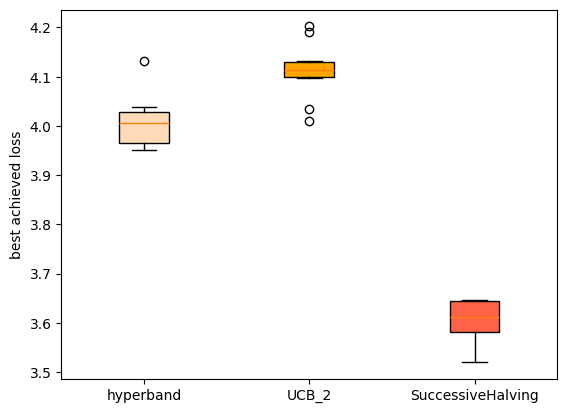

In [ ]:
import matplotlib.pyplot as plt
colors = ['peachpuff', 'orange', 'tomato', "green", "black"]

fig, ax = plt.subplots()
ax.set_ylabel('best achieved loss')

bplot = ax.boxplot(losses,
                   tick_labels=labels,
                   patch_artist=True)  # will be used to label x-ticks

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

In [ ]:
from collections import defaultdict
import numpy as np

budgets = np.arange(5, 50, 5)

res = defaultdict(list)
for BUDGET in budgets:
    hyperband_bests = [get_best_alg(run_res, budget=BUDGET) for run_res in hyperband_res[0]]
    hyperband_bests = [(hyperband_res[1][hr["alg_name"]], hr["pull_rew.eval_rez.loss"]) for hr in hyperband_bests]


    def get_other_res(other_res):
        alg_names = other_res[1]
        alg_res = other_res[0]
        alg_bests = [get_best_alg(res,budget=BUDGET) for res in alg_res]
        best_alg = [(alg_names[ab["pulled_arm"]], ab['pull_rew.eval_rez.loss']) for ab in alg_bests]
        return best_alg

    others_rank = [get_other_res(res) for res in others_res]

    result = {"hyperband": hyperband_bests, **{rn[10:-1]: rr for rn, rr in zip(run_names, others_rank)}}
    for k, v in result.items():
        res[k].append(np.mean([(a[0] == "ResNet18") for a in v]))

    

[{'alg_name': 11, 'pull_rew.confidence_bound': 0.7071067811865475, 'pull_rew.value': 4.554399806213379, 'pull_rew.eval_rez.loss': 4.554399806213379, 'pull_rew.eval_rez.duration': 0.0, 'pull_rew.eval_rez.accuracy': 0.0192}, {'alg_name': 3, 'pull_rew.confidence_bound': 0.7071067811865475, 'pull_rew.value': 4.608605107879638, 'pull_rew.eval_rez.loss': 4.608605107879638, 'pull_rew.eval_rez.duration': 0.0, 'pull_rew.eval_rez.accuracy': 0.0086}, {'alg_name': 3, 'pull_rew.confidence_bound': 1.0, 'pull_rew.value': 4.615856172943115, 'pull_rew.eval_rez.loss': 4.615856172943115, 'pull_rew.eval_rez.duration': 0.0, 'pull_rew.eval_rez.accuracy': 0.01}, {'alg_name': 10, 'pull_rew.confidence_bound': 1.0, 'pull_rew.value': 4.621876321411133, 'pull_rew.eval_rez.loss': 4.621876321411133, 'pull_rew.eval_rez.duration': 0.0, 'pull_rew.eval_rez.accuracy': 0.0094}, {'alg_name': 11, 'pull_rew.confidence_bound': 1.0, 'pull_rew.value': 4.629308359527588, 'pull_rew.eval_rez.loss': 4.629308359527588, 'pull_rew.ev

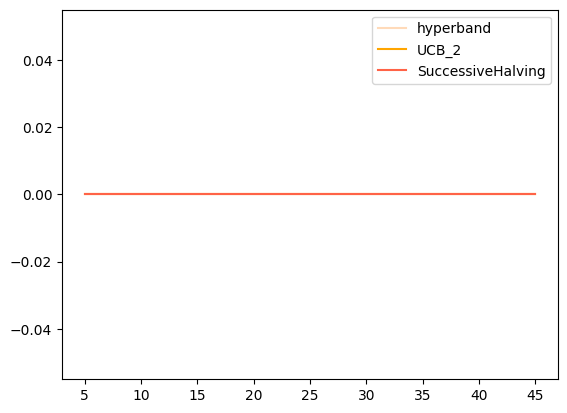

In [ ]:
colors = ['peachpuff', 'orange', 'tomato', "green", "black"]
for color, (k, v) in zip(colors, res.items()):
    plt.plot(budgets, v, label = k, color = color)
plt.legend()

regret

In [ ]:
def get_loss(run_results):
    losses = [[r["pull_rew.eval_rez.loss"] for r in res ]  for res in run_results]
    losses = np.array(losses).mean(0).cumsum(0)
    return  losses

regret = {"Hyperband": get_loss(hyperband_res[0]), **{rn[10:-1]: get_loss(rr[0]) for rn, rr in zip(run_names, others_res)}}

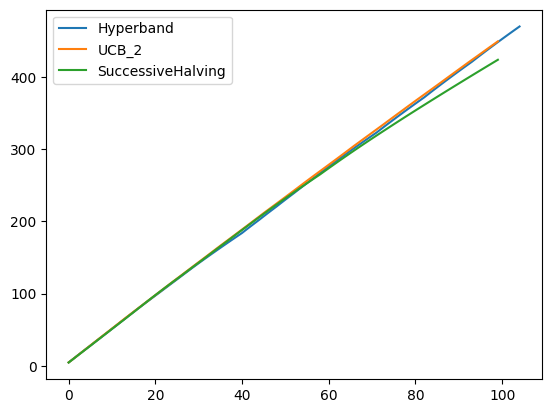

In [ ]:
for k, v in regret.items():
    plt.plot(v, label = k)
plt.legend()